# Effects of COVID-19 on Select Army Futures Command Installations

#### Author: Peter Flaming

## Notebook Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import os
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Models can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common data science imports
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999

import seaborn as sns

from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import ColumnDataSource, ColorBar
from bokeh.palettes import Spectral6
from bokeh.transform import linear_cmap
from bokeh.plotting import figure
output_notebook()

# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_ID = "COVID-19"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "Images", PROJECT_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# Create function to save figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
warnings.simplefilter('ignore', DeprecationWarning)

Using plaidml.keras.backend backend.


No GPU was detected. Models can be very slow without a GPU.


Loading BokehJS ...

# Get the data

In [2]:
# Download data from URLs
US_Daily_URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/06-22-2020.csv"
US_Hospitals_URL = "https://raw.githubusercontent.com/PeterFlaming/COVID-19/master/Data/Hospitals.csv"
US_Current_URL = "https://covidtracking.com/api/v1/states/current.csv"

daily_raw = pd.read_csv(US_Daily_URL)
hospitals_raw = pd.read_csv(US_Hospitals_URL)
current_raw = pd.read_csv(US_Current_URL)

In [3]:
daily_raw.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-06-23 04:33:35,32.3182,-86.9023,30454,841,15974.0,13639.0,1,621.106485,349110.0,2471.0,2.761542,84000001,USA,7120.065835,8.113877
1,Alaska,US,2020-06-23 04:33:35,61.3707,-152.4044,758,12,491.0,255.0,2,103.616319,90824.0,NaN,1.583113,84000002,USA,12415.367476,NaN
2,American Samoa,US,2020-06-23 04:33:35,-14.2710,-170.1320,0,0,NaN,0.0,60,0.000000,174.0,NaN,NaN,16,ASM,312.719038,NaN
3,Arizona,US,2020-06-23 04:33:35,33.7298,-111.4312,54599,1351,7581.0,45667.0,4,750.118462,429790.0,4185.0,2.474404,84000004,USA,5904.749422,7.664976
4,Arkansas,US,2020-06-23 04:33:35,34.9697,-92.3731,16083,227,10793.0,5063.0,5,532.937195,256339.0,1164.0,1.411428,84000005,USA,8494.222952,7.237456


In [4]:
hospitals_raw.head()

,X,Y,FID,ID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,TELEPHONE,TYPE,STATUS,POPULATION,COUNTY,COUNTYFIPS,COUNTRY,LATITUDE,LONGITUDE,NAICS_CODE,NAICS_DESC,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,WEBSITE,STATE_ID,ALT_NAME,ST_FIPS,OWNER,TTL_STAFF,BEDS,TRAUMA,HELIPAD
0,-1.331889e+07,4.346975e+06,1,5793230,CENTRAL VALLEY GENERAL HOSPITAL,1025 NORTH DOUTY STREET,HANFORD,CA,93230,NOT AVAILABLE,NOT AVAILABLE,GENERAL ACUTE CARE,CLOSED,49,KINGS,06031,USA,36.336159,-119.645667,622110,GENERAL MEDICAL AND SURGICAL HOSPITALS,http://www.oshpd.ca.gov/hid/facility-listing.html,2016/02/04 00:00:00,IMAGERY/OTHER,2014/02/10 00:00:00,http://www.hanfordhealth.com,NOT AVAILABLE,NOT AVAILABLE,6,PROPRIETARY,-999,49,NOT AVAILABLE,N
1,-1.322651e+07,4.049626e+06,2,53391362,LOS ROBLES HOSPITAL & MEDICAL CENTER - EAST CAMPUS,150 VIA MERIDA,WESTLAKE VILAGE,CA,91362,NOT AVAILABLE,NOT AVAILABLE,GENERAL ACUTE CARE,OPEN,62,VENTURA,06111,USA,34.154939,-118.815736,622110,GENERAL MEDICAL AND SURGICAL HOSPITALS,http://www.oshpd.ca.gov/hid/facility-listing.html,2019/08/02 00:00:00,IMAGERY/OTHER,2014/02/10 00:00:00,http://www.losrobleshospital.com,NOT AVAILABLE,NOT AVAILABLE,6,PROPRIETARY,-999,62,NOT AVAILABLE,N
2,-1.315620e+07,4.031978e+06,3,11190023,EAST LOS ANGELES DOCTORS HOSPITAL,4060 WHITTIER BOULEVARD,LOS ANGELES,CA,90023,NOT AVAILABLE,NOT AVAILABLE,GENERAL ACUTE CARE,OPEN,127,LOS ANGELES,06037,USA,34.023647,-118.184165,622110,GENERAL MEDICAL AND SURGICAL HOSPITALS,http://www.oshpd.ca.gov/hid/facility-listing.html,2019/08/02 00:00:00,IMAGERY/OTHER,2014/02/10 00:00:00,http://www.elalax.com,NOT AVAILABLE,NOT AVAILABLE,6,PROPRIETARY,-999,127,NOT AVAILABLE,N
3,-1.317190e+07,4.041752e+06,4,17090028,SOUTHERN CALIFORNIA HOSPITAL AT HOLLYWOOD,6245 DE LONGPRE AVENUE,HOLLYWOOD,CA,90028,NOT AVAILABLE,(323) 462-2271,GENERAL ACUTE CARE,OPEN,100,LOS ANGELES,06037,USA,34.096391,-118.325235,622110,GENERAL MEDICAL AND SURGICAL HOSPITALS,http://www.oshpd.ca.gov/hid/facility-listing.html,2019/08/02 00:00:00,IMAGERY/OTHER,2014/02/10 00:00:00,http://sch-hollywood.com/,NOT AVAILABLE,HOLLYWOOD COMMUNITY HOSPITAL OF HOLLYWOOD,6,PROPRIETARY,-999,100,NOT AVAILABLE,N
4,-1.313208e+07,4.037270e+06,5,23691706,KINDRED HOSPITAL BALDWIN PARK,14148 FRANCISQUITO AVENUE,BALDWIN PARK,CA,91706,NOT AVAILABLE,NOT AVAILABLE,GENERAL ACUTE CARE,OPEN,95,LOS ANGELES,06037,USA,34.063039,-117.967438,622110,GENERAL MEDICAL AND SURGICAL HOSPITALS,http://www.oshpd.ca.gov/hid/facility-listing.html,2019/08/02 00:00:00,IMAGERY/OTHER,2014/02/10 00:00:00,http://www.khbaldwinpark.com,NOT AVAILABLE,NOT AVAILABLE,6,PROPRIETARY,-999,95,NOT AVAILABLE,N


In [5]:
current_raw.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20200623,AK,778,92169.0,NaN,14.0,NaN,NaN,NaN,1.0,NaN,502.0,A,6/23/2020 00:00,2020-06-23T00:00:00Z,06/22 20:00,12,NaN,2020-06-23T00:00:00Z,92947.0,NaN,NaN,NaN,2,17,2106,92947,92947,2123,92947,0,0,f35d9d60a800f017ff47a041f47e0d05531a0a5d,0,0,0,0,0,NaN
1,20200623,AL,31097,322941.0,NaN,680.0,2521.0,NaN,737.0,NaN,430.0,15974.0,B,6/23/2020 11:00,2020-06-23T11:00:00Z,06/23 07:00,864,2521.0,2020-06-23T11:00:00Z,NaN,NaN,NaN,30670.0,1,643,4285,354038,354038,4928,354038,23,50,d0d195d69fd8e81e5ab80f001a6c0919dbdcf204,0,0,0,0,0,NaN
2,20200623,AR,16678,247814.0,NaN,248.0,1188.0,NaN,NaN,57.0,186.0,11220.0,A,6/23/2020 14:50,2020-06-23T14:50:00Z,06/23 10:50,237,1188.0,2020-06-23T14:50:00Z,NaN,NaN,NaN,16678.0,5,595,7558,264492,264492,8153,264492,10,24,85ada121319e67e007e948504ed59ad41d6e8df9,0,0,0,0,0,NaN
3,20200623,AS,0,174.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,6/1/2020 00:00,2020-06-01T00:00:00Z,05/31 20:00,0,NaN,2020-06-01T00:00:00Z,NaN,NaN,NaN,NaN,60,0,0,174,174,0,174,0,0,0d9d878b490e6460c45ff06c325b3f28f1419ee8,0,0,0,0,0,NaN
4,20200623,AZ,58179,382339.0,NaN,2136.0,4255.0,614.0,NaN,386.0,NaN,7746.0,A+,6/23/2020 00:00,2020-06-23T00:00:00Z,06/22 20:00,1384,4255.0,2020-06-23T00:00:00Z,440138.0,NaN,NaN,57799.0,4,3593,7135,440518,440518,10728,440518,42,0,d80761e660fa46dfc4d7747eba8a6bcb8216783c,0,0,0,0,0,NaN


In [6]:
# Save data to repo as a backup
daily_raw.to_csv("./Data/csse_covid_US_06-22-2020.csv")
current_raw.to_csv("./Data/covid_tracker_api_06-22-2020.csv")

In [7]:
# Create copies of raw data cleaning and munging
daily = daily_raw.copy()
hospitals = hospitals_raw.copy()
current = current_raw.copy()

In [8]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Province_State        58 non-null     object 
 1   Country_Region        58 non-null     object 
 2   Last_Update           58 non-null     object 
 3   Lat                   56 non-null     float64
 4   Long_                 56 non-null     float64
 5   Confirmed             58 non-null     int64  
 6   Deaths                58 non-null     int64  
 7   Recovered             46 non-null     float64
 8   Active                58 non-null     float64
 9   FIPS                  58 non-null     int64  
 10  Incident_Rate         56 non-null     float64
 11  People_Tested         56 non-null     float64
 12  People_Hospitalized   36 non-null     float64
 13  Mortality_Rate        57 non-null     float64
 14  UID                   58 non-null     int64  
 15  ISO3                  58 

In [9]:
import re

# Create function to delete times from dates
def cleanup_date(date): 
    time = ["04:33:35"]

    for s in time:
        date = re.sub(s, '', date)
    return date

In [10]:
daily['Last_Update'] = daily.Last_Update.apply(cleanup_date)
daily.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-06-23,32.3182,-86.9023,30454,841,15974.0,13639.0,1,621.106485,349110.0,2471.0,2.761542,84000001,USA,7120.065835,8.113877
1,Alaska,US,2020-06-23,61.3707,-152.4044,758,12,491.0,255.0,2,103.616319,90824.0,NaN,1.583113,84000002,USA,12415.367476,NaN
2,American Samoa,US,2020-06-23,-14.2710,-170.1320,0,0,NaN,0.0,60,0.000000,174.0,NaN,NaN,16,ASM,312.719038,NaN
3,Arizona,US,2020-06-23,33.7298,-111.4312,54599,1351,7581.0,45667.0,4,750.118462,429790.0,4185.0,2.474404,84000004,USA,5904.749422,7.664976
4,Arkansas,US,2020-06-23,34.9697,-92.3731,16083,227,10793.0,5063.0,5,532.937195,256339.0,1164.0,1.411428,84000005,USA,8494.222952,7.237456


In [11]:
daily.rename(columns={"Province_State": "State", "Last_Update": "Date", "Long_": "Long"}, inplace=True)
daily.head()

,State,Country_Region,Date,Lat,Long,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-06-23,32.3182,-86.9023,30454,841,15974.0,13639.0,1,621.106485,349110.0,2471.0,2.761542,84000001,USA,7120.065835,8.113877
1,Alaska,US,2020-06-23,61.3707,-152.4044,758,12,491.0,255.0,2,103.616319,90824.0,NaN,1.583113,84000002,USA,12415.367476,NaN
2,American Samoa,US,2020-06-23,-14.2710,-170.1320,0,0,NaN,0.0,60,0.000000,174.0,NaN,NaN,16,ASM,312.719038,NaN
3,Arizona,US,2020-06-23,33.7298,-111.4312,54599,1351,7581.0,45667.0,4,750.118462,429790.0,4185.0,2.474404,84000004,USA,5904.749422,7.664976
4,Arkansas,US,2020-06-23,34.9697,-92.3731,16083,227,10793.0,5063.0,5,532.937195,256339.0,1164.0,1.411428,84000005,USA,8494.222952,7.237456


In [12]:
daily_subset = daily.drop(["Country_Region", "FIPS", "UID", "ISO3"], axis=1)
daily_subset.head()

,State,Date,Lat,Long,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
0,Alabama,2020-06-23,32.3182,-86.9023,30454,841,15974.0,13639.0,621.106485,349110.0,2471.0,2.761542,7120.065835,8.113877
1,Alaska,2020-06-23,61.3707,-152.4044,758,12,491.0,255.0,103.616319,90824.0,NaN,1.583113,12415.367476,NaN
2,American Samoa,2020-06-23,-14.2710,-170.1320,0,0,NaN,0.0,0.000000,174.0,NaN,NaN,312.719038,NaN
3,Arizona,2020-06-23,33.7298,-111.4312,54599,1351,7581.0,45667.0,750.118462,429790.0,4185.0,2.474404,5904.749422,7.664976
4,Arkansas,2020-06-23,34.9697,-92.3731,16083,227,10793.0,5063.0,532.937195,256339.0,1164.0,1.411428,8494.222952,7.237456


In [13]:
print(daily_subset.shape)
daily_subset.isna().sum()

(58, 14)


State                    0
Date                     0
Lat                      2
Long                     2
Confirmed                0
Deaths                   0
Recovered               12
Active                   0
Incident_Rate            2
People_Tested            2
People_Hospitalized     22
Mortality_Rate           1
Testing_Rate             2
Hospitalization_Rate    22
dtype: int64

In [14]:
daily_subset.describe()

,Lat,Long,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
count,56.000000,56.000000,58.000000,58.000000,46.000000,58.000000,56.000000,5.600000e+01,36.000000,57.000000,56.000000,36.000000
mean,36.840089,-85.206614,39867.275862,2075.896552,13917.347826,26753.482759,593.366127,4.920282e+05,6474.972222,3.937786,8194.026763,12.120362
std,10.887035,49.754449,62761.656383,4585.926403,18626.524809,50715.796049,458.509670,6.854400e+05,15012.777347,2.167281,3755.398945,4.270112
min,-14.271000,-170.132000,0.000000,0.000000,19.000000,0.000000,0.000000,1.740000e+02,90.000000,0.000000,223.767031,6.472028
25%,34.594600,-101.165775,4581.500000,92.250000,1585.750000,821.500000,262.990039,9.524825e+04,1034.250000,2.324177,5904.076146,8.526675
50%,39.061850,-87.944200,17934.500000,533.000000,5948.000000,8113.000000,504.250809,2.881015e+05,2386.000000,3.437675,7888.044062,11.830276
75%,42.361650,-76.970625,49124.750000,2068.000000,16991.500000,22938.000000,723.837956,5.731082e+05,6937.250000,5.319149,9527.459642,14.692264
max,61.370700,145.673900,388488.000000,31176.000000,69710.000000,287602.000000,1997.001988,3.452099e+06,89995.000000,9.311520,20641.499923,23.165452


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f95863fbf10>,
      dtype=object)

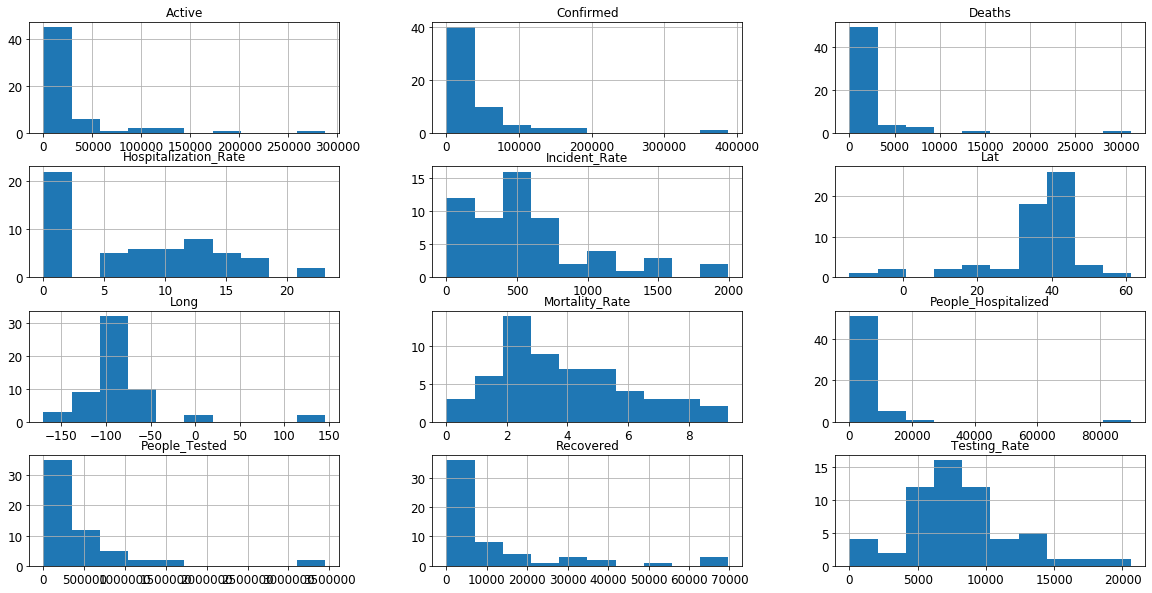

In [15]:
states = daily_subset.fillna(0)
states.hist()

In [47]:
# Map the lowering function to all column names
states.columns = map(str.lower, states.columns)

In [48]:
# Save daily state data to repo as a backup
states.to_csv("./Data/states.csv")

In [17]:
hospitals.head()

,X,Y,FID,ID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,TELEPHONE,TYPE,STATUS,POPULATION,COUNTY,COUNTYFIPS,COUNTRY,LATITUDE,LONGITUDE,NAICS_CODE,NAICS_DESC,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,WEBSITE,STATE_ID,ALT_NAME,ST_FIPS,OWNER,TTL_STAFF,BEDS,TRAUMA,HELIPAD
0,-1.331889e+07,4.346975e+06,1,5793230,CENTRAL VALLEY GENERAL HOSPITAL,1025 NORTH DOUTY STREET,HANFORD,CA,93230,NOT AVAILABLE,NOT AVAILABLE,GENERAL ACUTE CARE,CLOSED,49,KINGS,06031,USA,36.336159,-119.645667,622110,GENERAL MEDICAL AND SURGICAL HOSPITALS,http://www.oshpd.ca.gov/hid/facility-listing.html,2016/02/04 00:00:00,IMAGERY/OTHER,2014/02/10 00:00:00,http://www.hanfordhealth.com,NOT AVAILABLE,NOT AVAILABLE,6,PROPRIETARY,-999,49,NOT AVAILABLE,N
1,-1.322651e+07,4.049626e+06,2,53391362,LOS ROBLES HOSPITAL & MEDICAL CENTER - EAST CAMPUS,150 VIA MERIDA,WESTLAKE VILAGE,CA,91362,NOT AVAILABLE,NOT AVAILABLE,GENERAL ACUTE CARE,OPEN,62,VENTURA,06111,USA,34.154939,-118.815736,622110,GENERAL MEDICAL AND SURGICAL HOSPITALS,http://www.oshpd.ca.gov/hid/facility-listing.html,2019/08/02 00:00:00,IMAGERY/OTHER,2014/02/10 00:00:00,http://www.losrobleshospital.com,NOT AVAILABLE,NOT AVAILABLE,6,PROPRIETARY,-999,62,NOT AVAILABLE,N
2,-1.315620e+07,4.031978e+06,3,11190023,EAST LOS ANGELES DOCTORS HOSPITAL,4060 WHITTIER BOULEVARD,LOS ANGELES,CA,90023,NOT AVAILABLE,NOT AVAILABLE,GENERAL ACUTE CARE,OPEN,127,LOS ANGELES,06037,USA,34.023647,-118.184165,622110,GENERAL MEDICAL AND SURGICAL HOSPITALS,http://www.oshpd.ca.gov/hid/facility-listing.html,2019/08/02 00:00:00,IMAGERY/OTHER,2014/02/10 00:00:00,http://www.elalax.com,NOT AVAILABLE,NOT AVAILABLE,6,PROPRIETARY,-999,127,NOT AVAILABLE,N
3,-1.317190e+07,4.041752e+06,4,17090028,SOUTHERN CALIFORNIA HOSPITAL AT HOLLYWOOD,6245 DE LONGPRE AVENUE,HOLLYWOOD,CA,90028,NOT AVAILABLE,(323) 462-2271,GENERAL ACUTE CARE,OPEN,100,LOS ANGELES,06037,USA,34.096391,-118.325235,622110,GENERAL MEDICAL AND SURGICAL HOSPITALS,http://www.oshpd.ca.gov/hid/facility-listing.html,2019/08/02 00:00:00,IMAGERY/OTHER,2014/02/10 00:00:00,http://sch-hollywood.com/,NOT AVAILABLE,HOLLYWOOD COMMUNITY HOSPITAL OF HOLLYWOOD,6,PROPRIETARY,-999,100,NOT AVAILABLE,N
4,-1.313208e+07,4.037270e+06,5,23691706,KINDRED HOSPITAL BALDWIN PARK,14148 FRANCISQUITO AVENUE,BALDWIN PARK,CA,91706,NOT AVAILABLE,NOT AVAILABLE,GENERAL ACUTE CARE,OPEN,95,LOS ANGELES,06037,USA,34.063039,-117.967438,622110,GENERAL MEDICAL AND SURGICAL HOSPITALS,http://www.oshpd.ca.gov/hid/facility-listing.html,2019/08/02 00:00:00,IMAGERY/OTHER,2014/02/10 00:00:00,http://www.khbaldwinpark.com,NOT AVAILABLE,NOT AVAILABLE,6,PROPRIETARY,-999,95,NOT AVAILABLE,N


In [78]:
hospitals_subset = hospitals[["STATE", "COUNTY", "STATUS", "POPULATION", "LATITUDE", "LONGITUDE", "TTL_STAFF", "BEDS"]]
hospitals_subset.head()

,STATE,COUNTY,STATUS,POPULATION,LATITUDE,LONGITUDE,TTL_STAFF,BEDS
0,CA,KINGS,CLOSED,49,36.336159,-119.645667,-999,49
1,CA,VENTURA,OPEN,62,34.154939,-118.815736,-999,62
2,CA,LOS ANGELES,OPEN,127,34.023647,-118.184165,-999,127
3,CA,LOS ANGELES,OPEN,100,34.096391,-118.325235,-999,100
4,CA,LOS ANGELES,OPEN,95,34.063039,-117.967438,-999,95


In [79]:
# Map the lowering function to all column names
hospitals_subset.columns = map(str.lower, hospitals_subset.columns)

In [80]:
hospitals_subset.isna().sum()

state         0
county        0
status        0
population    0
latitude      0
longitude     0
ttl_staff     0
beds          0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9591936750>,
      dtype=object)

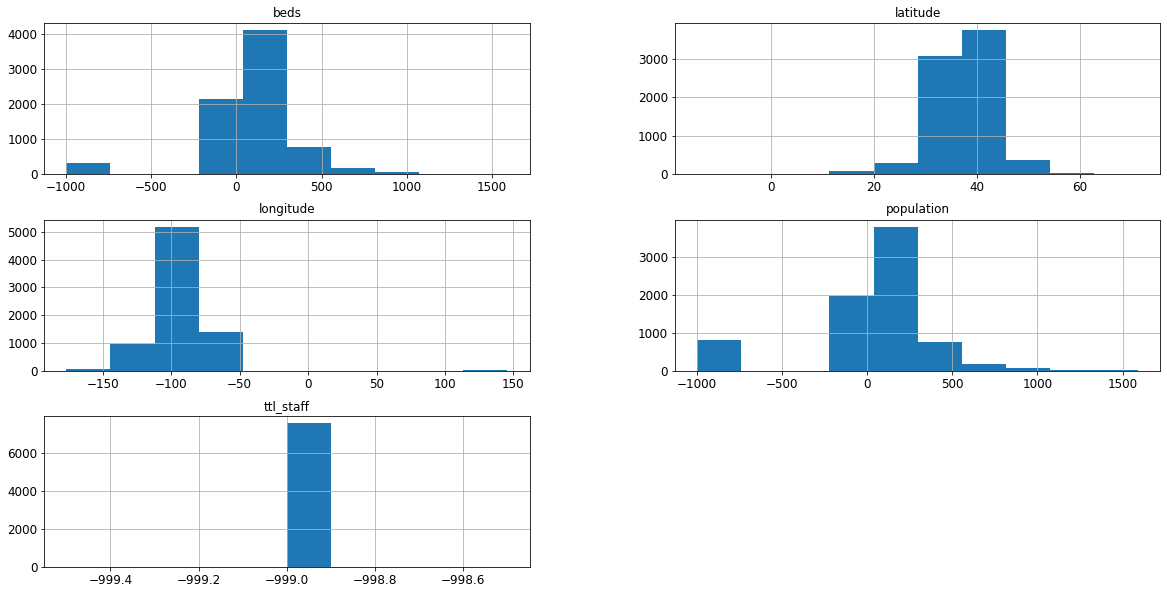

In [81]:
hospitals_subset.hist()

In [82]:

# us_state_abbrev = {
#     'Alabama': 'AL',
#     'Alaska': 'AK',
#     'American Samoa': 'AS',
#     'Arizona': 'AZ',
#     'Arkansas': 'AR',
#     'California': 'CA',
#     'Colorado': 'CO',
#     'Connecticut': 'CT',
#     'Delaware': 'DE',
#     'District of Columbia': 'DC',
#     'Florida': 'FL',
#     'Georgia': 'GA',
#     'Guam': 'GU',
#     'Hawaii': 'HI',
#     'Idaho': 'ID',
#     'Illinois': 'IL',
#     'Indiana': 'IN',
#     'Iowa': 'IA',
#     'Kansas': 'KS',
#     'Kentucky': 'KY',
#     'Louisiana': 'LA',
#     'Maine': 'ME',
#     'Maryland': 'MD',
#     'Massachusetts': 'MA',
#     'Michigan': 'MI',
#     'Minnesota': 'MN',
#     'Mississippi': 'MS',
#     'Missouri': 'MO',
#     'Montana': 'MT',
#     'Nebraska': 'NE',
#     'Nevada': 'NV',
#     'New Hampshire': 'NH',
#     'New Jersey': 'NJ',
#     'New Mexico': 'NM',
#     'New York': 'NY',
#     'North Carolina': 'NC',
#     'North Dakota': 'ND',
#     'Northern Mariana Islands':'MP',
#     'Ohio': 'OH',
#     'Oklahoma': 'OK',
#     'Oregon': 'OR',
#     'Pennsylvania': 'PA',
#     'Puerto Rico': 'PR',
#     'Rhode Island': 'RI',
#     'South Carolina': 'SC',
#     'South Dakota': 'SD',
#     'Tennessee': 'TN',
#     'Texas': 'TX',
#     'Utah': 'UT',
#     'Vermont': 'VT',
#     'Virgin Islands': 'VI',
#     'Virginia': 'VA',
#     'Washington': 'WA',
#     'West Virginia': 'WV',
#     'Wisconsin': 'WI',
#     'Wyoming': 'WY'
# }

# # thank you to @kinghelix and @trevormarburger for this idea
# abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))

# # Simple test examples
# if __name__ == '__main__':
#     print("Wisconin --> WI?", us_state_abbrev['Wisconsin'] == 'WI')
#     print("WI --> Wisconin?", abbrev_us_state['WI'] == 'Wisconsin')
#     print("Number of entries (50 states, DC, 5 Territories) == 56? ", 56 == len(us_state_abbrev))

In [83]:
us_state_abbrev = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AS': 'American Samoa',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': "Washington DC",
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming',
}
hospitals_subset["state"] = hospitals_subset["state"].map(us_state_abbrev)
hospitals_subset["state"].head()

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0    California
1    California
2    California
3    California
4    California
Name: state, dtype: object

In [84]:
hospitals_subset.head()

,state,county,status,population,latitude,longitude,ttl_staff,beds
0,California,KINGS,CLOSED,49,36.336159,-119.645667,-999,49
1,California,VENTURA,OPEN,62,34.154939,-118.815736,-999,62
2,California,LOS ANGELES,OPEN,127,34.023647,-118.184165,-999,127
3,California,LOS ANGELES,OPEN,100,34.096391,-118.325235,-999,100
4,California,LOS ANGELES,OPEN,95,34.063039,-117.967438,-999,95


In [85]:
# Let's replace negative values (-999) with 0
num = hospitals_subset._get_numeric_data()
num[num == -999] = 0
hospitals_subset.head()

,state,county,status,population,latitude,longitude,ttl_staff,beds
0,California,KINGS,CLOSED,49,36.336159,-119.645667,0,49
1,California,VENTURA,OPEN,62,34.154939,-118.815736,0,62
2,California,LOS ANGELES,OPEN,127,34.023647,-118.184165,0,127
3,California,LOS ANGELES,OPEN,100,34.096391,-118.325235,0,100
4,California,LOS ANGELES,OPEN,95,34.063039,-117.967438,0,95


In [86]:
# Save daily state data to repo as a backup
hospitals_subset.to_csv("./Data/hospital_subset.csv")

In [87]:
current.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20200623,Alaska,778,92169.0,NaN,14.0,NaN,NaN,NaN,1.0,NaN,502.0,A,6/23/2020 00:00,2020-06-23T00:00:00Z,06/22 20:00,12,NaN,2020-06-23T00:00:00Z,92947.0,NaN,NaN,NaN,2,17,2106,92947,92947,2123,92947,0,0,f35d9d60a800f017ff47a041f47e0d05531a0a5d,0,0,0,0,0,NaN
1,20200623,Alabama,31097,322941.0,NaN,680.0,2521.0,NaN,737.0,NaN,430.0,15974.0,B,6/23/2020 11:00,2020-06-23T11:00:00Z,06/23 07:00,864,2521.0,2020-06-23T11:00:00Z,NaN,NaN,NaN,30670.0,1,643,4285,354038,354038,4928,354038,23,50,d0d195d69fd8e81e5ab80f001a6c0919dbdcf204,0,0,0,0,0,NaN
2,20200623,Arkansas,16678,247814.0,NaN,248.0,1188.0,NaN,NaN,57.0,186.0,11220.0,A,6/23/2020 14:50,2020-06-23T14:50:00Z,06/23 10:50,237,1188.0,2020-06-23T14:50:00Z,NaN,NaN,NaN,16678.0,5,595,7558,264492,264492,8153,264492,10,24,85ada121319e67e007e948504ed59ad41d6e8df9,0,0,0,0,0,NaN
3,20200623,American Samoa,0,174.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,6/1/2020 00:00,2020-06-01T00:00:00Z,05/31 20:00,0,NaN,2020-06-01T00:00:00Z,NaN,NaN,NaN,NaN,60,0,0,174,174,0,174,0,0,0d9d878b490e6460c45ff06c325b3f28f1419ee8,0,0,0,0,0,NaN
4,20200623,Arizona,58179,382339.0,NaN,2136.0,4255.0,614.0,NaN,386.0,NaN,7746.0,A+,6/23/2020 00:00,2020-06-23T00:00:00Z,06/22 20:00,1384,4255.0,2020-06-23T00:00:00Z,440138.0,NaN,NaN,57799.0,4,3593,7135,440518,440518,10728,440518,42,0,d80761e660fa46dfc4d7747eba8a6bcb8216783c,0,0,0,0,0,NaN


In [88]:
current.isna().sum()

date                         0
state                        4
positive                     0
negative                     1
pending                     52
hospitalizedCurrently        7
hospitalizedCumulative      20
inIcuCurrently              30
inIcuCumulative             45
onVentilatorCurrently       31
onVentilatorCumulative      52
recovered                   10
dataQualityGrade             0
lastUpdateEt                 0
dateModified                 0
checkTimeEt                  0
death                        0
hospitalized                20
dateChecked                  0
totalTestsViral             29
positiveTestsViral          45
negativeTestsViral          45
positiveCasesViral           3
fips                         0
positiveIncrease             0
negativeIncrease             0
total                        0
totalTestResults             0
totalTestResultsIncrease     0
posNeg                       0
deathIncrease                0
hospitalizedIncrease         0
hash    

In [89]:
# Fix state abbreviations
current["state"] = current["state"].map(us_state_abbrev)
current["state"].head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: state, dtype: object

In [90]:
current.columns.to_list()

['date',
 'state',
 'positive',
 'negative',
 'pending',
 'hospitalizedCurrently',
 'hospitalizedCumulative',
 'inIcuCurrently',
 'inIcuCumulative',
 'onVentilatorCurrently',
 'onVentilatorCumulative',
 'recovered',
 'dataQualityGrade',
 'lastUpdateEt',
 'dateModified',
 'checkTimeEt',
 'death',
 'hospitalized',
 'dateChecked',
 'totalTestsViral',
 'positiveTestsViral',
 'negativeTestsViral',
 'positiveCasesViral',
 'fips',
 'positiveIncrease',
 'negativeIncrease',
 'total',
 'totalTestResults',
 'totalTestResultsIncrease',
 'posNeg',
 'deathIncrease',
 'hospitalizedIncrease',
 'hash',
 'commercialScore',
 'negativeRegularScore',
 'negativeScore',
 'positiveScore',
 'score',
 'grade']

In [91]:
current_subset = current[['date','state','positive','negative','hospitalizedCurrently','hospitalizedCumulative',
                          'inIcuCurrently','inIcuCumulative','onVentilatorCurrently','onVentilatorCumulative',
                          'recovered','death','hospitalized','totalTestsViral','positiveTestsViral',
                          'negativeTestsViral','positiveCasesViral','positiveIncrease','negativeIncrease','total',
                          'totalTestResults','totalTestResultsIncrease','posNeg','deathIncrease','hospitalizedIncrease',
                          'commercialScore','negativeRegularScore','negativeScore','positiveScore','score']]
current_subset.describe()

,date,positive,negative,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
count,56.0,56.000000,5.500000e+01,49.000000,36.000000,26.000000,11.000000,25.000000,4.000000,46.000000,56.000000,36.000000,2.700000e+01,11.000000,1.100000e+01,53.000000,56.000000,56.000000,5.600000e+01,5.600000e+01,56.000000,5.600000e+01,56.000000,56.000000,56.0,56.0,56.0,56.0,56.0
mean,20200623.0,41613.696429,4.679036e+05,610.612245,6511.833333,208.307692,916.090909,91.720000,229.500000,14077.130435,2050.160714,6511.833333,6.100487e+05,36304.454545,4.663770e+05,41031.509434,589.000000,8544.642857,5.011956e+05,5.011619e+05,9133.642857,5.011619e+05,12.553571,22.446429,0.0,0.0,0.0,0.0,0.0
std,0.0,63550.876336,6.433639e+05,945.562086,15016.502398,287.198993,694.965244,93.878698,134.691004,18755.497767,3955.686015,15016.502398,7.645969e+05,43148.212919,5.290738e+05,63813.748365,1134.655526,13483.293295,6.987013e+05,6.986589e+05,14356.704500,6.986589e+05,16.888856,40.896730,0.0,0.0,0.0,0.0,0.0
min,20200623.0,0.000000,1.740000e+02,0.000000,91.000000,0.000000,102.000000,0.000000,149.000000,19.000000,0.000000,91.000000,8.217000e+03,217.000000,1.022800e+04,30.000000,0.000000,0.000000,1.740000e+02,1.740000e+02,0.000000,1.740000e+02,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,20200623.0,6154.250000,9.320100e+04,105.000000,1037.750000,58.750000,343.000000,26.000000,152.000000,1619.000000,137.250000,1037.750000,8.732700e+04,2397.000000,7.876000e+04,6353.000000,26.250000,1143.000000,9.638875e+04,9.638875e+04,1176.750000,9.638875e+04,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,20200623.0,18221.500000,2.839760e+05,265.000000,2449.000000,131.000000,737.000000,66.000000,169.500000,6025.500000,607.500000,2449.000000,3.826100e+05,21737.000000,2.840290e+05,18300.000000,239.000000,4487.500000,2.965665e+05,2.965665e+05,5016.000000,2.965665e+05,5.000000,3.500000,0.0,0.0,0.0,0.0,0.0
75%,20200623.0,52309.500000,5.468635e+05,736.000000,6984.500000,236.750000,1319.000000,126.000000,247.000000,17076.250000,2307.250000,6984.500000,7.182125e+05,51998.500000,6.662140e+05,51595.000000,591.250000,10139.500000,5.854858e+05,5.852675e+05,10718.250000,5.852675e+05,17.250000,31.000000,0.0,0.0,0.0,0.0,0.0
max,20200623.0,389085.000000,3.313856e+06,5065.000000,89995.000000,1421.000000,2174.000000,386.000000,430.000000,70714.000000,24766.000000,89995.000000,3.496929e+06,135955.000000,1.805379e+06,389085.000000,5489.000000,80224.000000,3.500808e+06,3.500808e+06,85243.000000,3.500808e+06,67.000000,207.000000,0.0,0.0,0.0,0.0,0.0


In [92]:
# Fix the date format 
current_subset[['date']] = current_subset[['date']].applymap(str).applymap(
    lambda s: "{}-{}-{}".format(s[0:4], s[4:6],s[6:]))

print(current_subset[['date']])

          date
0   2020-06-23
1   2020-06-23
2   2020-06-23
3   2020-06-23
4   2020-06-23
5   2020-06-23
6   2020-06-23
7   2020-06-23
8   2020-06-23
9   2020-06-23
10  2020-06-23
11  2020-06-23
12  2020-06-23
13  2020-06-23
14  2020-06-23
15  2020-06-23
16  2020-06-23
17  2020-06-23
18  2020-06-23
19  2020-06-23
20  2020-06-23
21  2020-06-23
22  2020-06-23
23  2020-06-23
24  2020-06-23
25  2020-06-23
26  2020-06-23
27  2020-06-23
28  2020-06-23
29  2020-06-23
30  2020-06-23
31  2020-06-23
32  2020-06-23
33  2020-06-23
34  2020-06-23
35  2020-06-23
36  2020-06-23
37  2020-06-23
38  2020-06-23
39  2020-06-23
40  2020-06-23
41  2020-06-23
42  2020-06-23
43  2020-06-23
44  2020-06-23
45  2020-06-23
46  2020-06-23
47  2020-06-23
48  2020-06-23
49  2020-06-23
50  2020-06-23
51  2020-06-23
52  2020-06-23
53  2020-06-23
54  2020-06-23
55  2020-06-23


/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [93]:
counties = current_subset.fillna(0)
counties.columns = map(str.lower, counties.columns)
counties.head()

,date,state,positive,negative,hospitalizedcurrently,hospitalizedcumulative,inicucurrently,inicucumulative,onventilatorcurrently,onventilatorcumulative,recovered,death,hospitalized,totaltestsviral,positivetestsviral,negativetestsviral,positivecasesviral,positiveincrease,negativeincrease,total,totaltestresults,totaltestresultsincrease,posneg,deathincrease,hospitalizedincrease,commercialscore,negativeregularscore,negativescore,positivescore,score
0,2020-06-23,0,778,92169.0,14.0,0.0,0.0,0.0,1.0,0.0,502.0,12,0.0,92947.0,0.0,0.0,0.0,17,2106,92947,92947,2123,92947,0,0,0,0,0,0,0
1,2020-06-23,0,31097,322941.0,680.0,2521.0,0.0,737.0,0.0,430.0,15974.0,864,2521.0,0.0,0.0,0.0,30670.0,643,4285,354038,354038,4928,354038,23,50,0,0,0,0,0
2,2020-06-23,0,16678,247814.0,248.0,1188.0,0.0,0.0,57.0,186.0,11220.0,237,1188.0,0.0,0.0,0.0,16678.0,595,7558,264492,264492,8153,264492,10,24,0,0,0,0,0
3,2020-06-23,0,0,174.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,174,174,0,174,0,0,0,0,0,0,0
4,2020-06-23,0,58179,382339.0,2136.0,4255.0,614.0,0.0,386.0,0.0,7746.0,1384,4255.0,440138.0,0.0,0.0,57799.0,3593,7135,440518,440518,10728,440518,42,0,0,0,0,0,0


In [94]:
# Save daily county  data to repo as a backup
counties.to_csv("./Data/counties.csv")

In [95]:
daily_covid = pd.concat([states, counties], axis=1)

daily_covid.head(100)

,state,date,lat,long,confirmed,deaths,recovered,active,incident_rate,people_tested,people_hospitalized,mortality_rate,testing_rate,hospitalization_rate,date,state,positive,negative,hospitalizedcurrently,hospitalizedcumulative,inicucurrently,inicucumulative,onventilatorcurrently,onventilatorcumulative,recovered,death,hospitalized,totaltestsviral,positivetestsviral,negativetestsviral,positivecasesviral,positiveincrease,negativeincrease,total,totaltestresults,totaltestresultsincrease,posneg,deathincrease,hospitalizedincrease,commercialscore,negativeregularscore,negativescore,positivescore,score
0,Alabama,2020-06-23,32.3182,-86.9023,30454,841,15974.0,13639.0,621.106485,349110.0,2471.0,2.761542,7120.065835,8.113877,2020-06-23,0.0,778.0,92169.0,14.0,0.0,0.0,0.0,1.0,0.0,502.0,12.0,0.0,92947.0,0.0,0.0,0.0,17.0,2106.0,92947.0,92947.0,2123.0,92947.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alaska,2020-06-23,61.3707,-152.4044,758,12,491.0,255.0,103.616319,90824.0,0.0,1.583113,12415.367476,0.000000,2020-06-23,0.0,31097.0,322941.0,680.0,2521.0,0.0,737.0,0.0,430.0,15974.0,864.0,2521.0,0.0,0.0,0.0,30670.0,643.0,4285.0,354038.0,354038.0,4928.0,354038.0,23.0,50.0,0.0,0.0,0.0,0.0,0.0
2,American Samoa,2020-06-23,-14.2710,-170.1320,0,0,0.0,0.0,0.000000,174.0,0.0,0.000000,312.719038,0.000000,2020-06-23,0.0,16678.0,247814.0,248.0,1188.0,0.0,0.0,57.0,186.0,11220.0,237.0,1188.0,0.0,0.0,0.0,16678.0,595.0,7558.0,264492.0,264492.0,8153.0,264492.0,10.0,24.0,0.0,0.0,0.0,0.0,0.0
3,Arizona,2020-06-23,33.7298,-111.4312,54599,1351,7581.0,45667.0,750.118462,429790.0,4185.0,2.474404,5904.749422,7.664976,2020-06-23,0.0,0.0,174.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,174.0,174.0,0.0,174.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Arkansas,2020-06-23,34.9697,-92.3731,16083,227,10793.0,5063.0,532.937195,256339.0,1164.0,1.411428,8494.222952,7.237456,2020-06-23,0.0,58179.0,382339.0,2136.0,4255.0,614.0,0.0,386.0,0.0,7746.0,1384.0,4255.0,440138.0,0.0,0.0,57799.0,3593.0,7135.0,440518.0,440518.0,10728.0,440518.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0
5,California,2020-06-23,36.1162,-119.6816,184765,5566,0.0,179199.0,467.614794,3411686.0,0.0,3.012475,8634.507858,0.000000,2020-06-23,0.0,183073.0,3313856.0,5065.0,0.0,1421.0,0.0,0.0,0.0,0.0,5580.0,0.0,3496929.0,0.0,0.0,183073.0,5019.0,80224.0,3496929.0,3496929.0,85243.0,3496929.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Colorado,2020-06-23,39.0598,-105.3111,30689,1651,4328.0,24710.0,532.912083,282772.0,5327.0,5.379778,4910.313652,17.358011,2020-06-23,0.0,30705.0,257171.0,249.0,5343.0,0.0,0.0,0.0,0.0,4342.0,1651.0,5343.0,0.0,0.0,0.0,27959.0,166.0,4938.0,287876.0,287876.0,5104.0,287876.0,4.0,16.0,0.0,0.0,0.0,0.0,0.0
7,Connecticut,2020-06-23,41.5978,-72.7554,45782,4263,7842.0,33677.0,1284.104197,397552.0,10099.0,9.311520,11150.631071,22.058888,2020-06-23,0.0,45899.0,358045.0,138.0,10099.0,0.0,0.0,0.0,0.0,7842.0,4277.0,10099.0,401986.0,0.0,0.0,43941.0,117.0,6275.0,403944.0,403944.0,6392.0,403944.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Delaware,2020-06-23,39.3185,-75.5071,10820,435,6459.0,3926.0,1111.152189,96723.0,0.0,4.020333,9932.899553,0.000000,2020-06-23,0.0,10094.0,73208.0,171.0,0.0,61.0,0.0,40.0,0.0,1182.0,537.0,0.0,0.0,0.0,0.0,10094.0,36.0,1262.0,83302.0,83302.0,1298.0,83302.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Diamond Princess,2020-06-23,0.0000,0.0000,49,0,0.0,49.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,2020-06-23,0.0,10847.0,86689.0,91.0,0.0,0.0,0.0,0.0,0.0,6554.0,504.0,0.0,0.0,0.0,0.0,9792.0,27.0,786.0,97536.0,97536.0,813.0,97536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
print(daily_covid.shape)
daily_covid.tail()

(58, 44)


,state,date,lat,long,confirmed,deaths,recovered,active,incident_rate,people_tested,people_hospitalized,mortality_rate,testing_rate,hospitalization_rate,date,state,positive,negative,hospitalizedcurrently,hospitalizedcumulative,inicucurrently,inicucumulative,onventilatorcurrently,onventilatorcumulative,recovered,death,hospitalized,totaltestsviral,positivetestsviral,negativetestsviral,positivecasesviral,positiveincrease,negativeincrease,total,totaltestresults,totaltestresultsincrease,posneg,deathincrease,hospitalizedincrease,commercialscore,negativeregularscore,negativescore,positivescore,score
53,Virginia,2020-06-23,37.7693,-78.1700,58465,1620,7663.0,49182.0,684.961278,558123.0,8511.0,2.770889,6538.829098,14.557428,2020-06-23,0.0,25331.0,478165.0,240.0,3268.0,93.0,716.0,0.0,0.0,19852.0,750.0,3268.0,0.0,0.0,0.0,25331.0,263.0,11531.0,503638.0,503496.0,11794.0,503496.0,5.0,37.0,0.0,0.0,0.0,0.0,0.0
54,Washington,2020-06-23,47.4009,-121.4905,28870,1276,0.0,27594.0,379.125485,474938.0,4049.0,4.419813,6236.962227,14.024939,2020-06-23,0.0,2582.0,151746.0,21.0,0.0,5.0,0.0,2.0,0.0,1790.0,92.0,0.0,0.0,0.0,0.0,2493.0,30.0,3094.0,154328.0,154328.0,3124.0,154328.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
55,West Virginia,2020-06-23,38.4912,-80.9545,2552,89,1681.0,782.0,142.399033,151204.0,0.0,3.487461,8437.031114,0.000000,2020-06-23,0.0,1254.0,27485.0,8.0,109.0,0.0,0.0,0.0,0.0,953.0,20.0,109.0,38300.0,1149.0,37151.0,992.0,24.0,1323.0,28739.0,28739.0,1347.0,28739.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
56,Wisconsin,2020-06-23,44.2685,-89.6165,25068,745,19543.0,4780.0,430.541591,491702.0,3231.0,2.971916,8444.956182,12.888942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,Wyoming,2020-06-23,42.7560,-107.3025,1230,20,931.0,279.0,212.523693,27392.0,105.0,1.626016,4732.885363,8.536585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


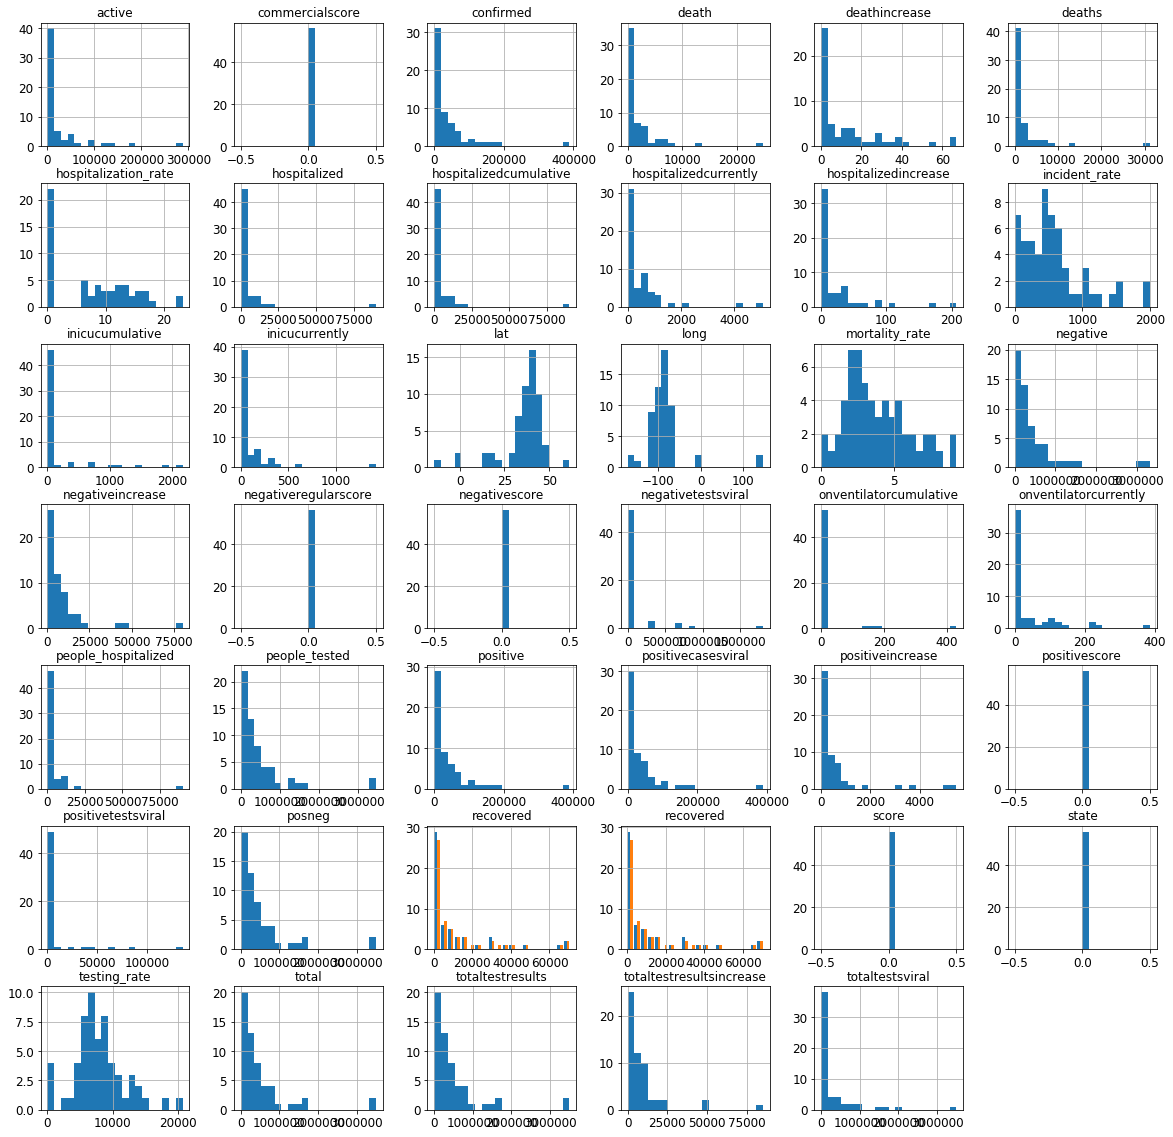

In [97]:
daily_covid.hist(bins=20, figsize=(20,20))
plt.show()

In [98]:
daily_covid.isna().sum()

state                       0
date                        0
lat                         0
long                        0
confirmed                   0
deaths                      0
recovered                   0
active                      0
incident_rate               0
people_tested               0
people_hospitalized         0
mortality_rate              0
testing_rate                0
hospitalization_rate        0
date                        2
state                       2
positive                    2
negative                    2
hospitalizedcurrently       2
hospitalizedcumulative      2
inicucurrently              2
inicucumulative             2
onventilatorcurrently       2
onventilatorcumulative      2
recovered                   2
death                       2
hospitalized                2
totaltestsviral             2
positivetestsviral          2
negativetestsviral          2
positivecasesviral          2
positiveincrease            2
negativeincrease            2
total     

In [99]:
covid = daily_covid.fillna(0)

In [100]:
covid.isna().sum()

state                       0
date                        0
lat                         0
long                        0
confirmed                   0
deaths                      0
recovered                   0
active                      0
incident_rate               0
people_tested               0
people_hospitalized         0
mortality_rate              0
testing_rate                0
hospitalization_rate        0
date                        0
state                       0
positive                    0
negative                    0
hospitalizedcurrently       0
hospitalizedcumulative      0
inicucurrently              0
inicucumulative             0
onventilatorcurrently       0
onventilatorcumulative      0
recovered                   0
death                       0
hospitalized                0
totaltestsviral             0
positivetestsviral          0
negativetestsviral          0
positivecasesviral          0
positiveincrease            0
negativeincrease            0
total     

In [101]:
covid.describe()

,lat,long,confirmed,deaths,recovered,active,incident_rate,people_tested,people_hospitalized,mortality_rate,testing_rate,hospitalization_rate,state,positive,negative,hospitalizedcurrently,hospitalizedcumulative,inicucurrently,inicucumulative,onventilatorcurrently,onventilatorcumulative,recovered,death,hospitalized,totaltestsviral,positivetestsviral,negativetestsviral,positivecasesviral,positiveincrease,negativeincrease,total,totaltestresults,totaltestresultsincrease,posneg,deathincrease,hospitalizedincrease,commercialscore,negativeregularscore,negativescore,positivescore,score
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,5.800000e+01,58.000000,58.000000,58.000000,58.000000,58.0,58.000000,5.800000e+01,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,5.800000e+01,58.000000,5.800000e+01,58.000000,58.000000,58.000000,5.800000e+01,5.800000e+01,58.000000,5.800000e+01,58.000000,58.000000,58.0,58.0,58.0,58.0,58.0
mean,35.569741,-82.268455,39867.275862,2075.896552,11037.896552,26753.482759,572.905226,4.750617e+05,4018.948276,3.869894,7911.474116,7.522983,0.0,40178.741379,4.437017e+05,515.862069,4041.827586,93.379310,173.741379,39.534483,15.827586,11164.620690,1979.465517,4041.827586,2.839882e+05,6885.327586,8.845081e+04,37494.310345,568.689655,8250.000000,4.839130e+05,4.838804e+05,8818.689655,4.838804e+05,12.120690,21.672414,0.0,0.0,0.0,0.0,0.0
std,12.662834,51.328392,62761.656383,4585.926403,17499.901322,50715.796049,463.446217,6.793706e+05,12183.479363,2.209536,3985.323578,6.810947,0.0,62894.123713,6.348691e+05,895.908173,12191.002302,217.018621,464.728238,76.224326,66.302904,17629.511343,3903.948286,12191.002302,6.007373e+05,23081.161800,2.883105e+05,62047.852745,1119.831523,13337.680762,6.925058e+05,6.924637e+05,14202.431561,6.924637e+05,16.750049,40.384724,0.0,0.0,0.0,0.0,0.0
min,-14.271000,-170.132000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,33.761575,-99.697700,4581.500000,92.250000,252.500000,821.500000,227.364238,8.420900e+04,0.000000,2.283512,5707.668395,0.000000,0.0,4580.000000,8.070700e+04,21.750000,0.000000,0.000000,0.000000,0.000000,0.000000,256.000000,94.500000,0.000000,0.000000e+00,0.000000,0.000000e+00,2821.250000,23.250000,736.500000,8.571325e+04,8.571325e+04,744.000000,8.571325e+04,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,38.978600,-86.797300,17934.500000,533.000000,3419.500000,8113.000000,483.054102,2.827150e+05,584.500000,3.435431,7691.647376,7.889426,0.0,18050.000000,2.699045e+05,209.000000,591.000000,0.000000,0.000000,0.000000,0.000000,3498.000000,539.500000,591.000000,0.000000e+00,0.000000,0.000000e+00,17317.500000,233.500000,4372.000000,2.914665e+05,2.914665e+05,4786.500000,2.914665e+05,4.500000,2.500000,0.0,0.0,0.0,0.0,0.0
75%,42.214075,-75.830850,49124.750000,2068.000000,11530.250000,22938.000000,707.548660,5.468765e+05,3143.500000,5.293686,9378.264083,12.732102,0.0,50228.000000,5.036812e+05,659.500000,3179.750000,98.250000,0.000000,47.500000,0.000000,12232.750000,2077.750000,3179.750000,3.123255e+05,0.000000,0.000000e+00,43673.500000,574.750000,10009.250000,5.565122e+05,5.562940e+05,10699.000000,5.562940e+05,16.750000,28.500000,0.0,0.0,0.0,0.0,0.0
max,61.370700,145.673900,388488.000000,31176.000000,69710.000000,287602.000000,1997.001988,3.452099e+06,89995.000000,9.311520,20641.499923,23.165452,0.0,389085.000000,3.313856e+06,5065.000000,89995.000000,1421.000000,2174.000000,386.000000,430.000000,70714.000000,24766.000000,89995.000000,3.496929e+06,135955.000000,1.805379e+06,389085.000000,5489.000000,80224.000000,3.500808e+06,3.500808e+06,85243.000000,3.500808e+06,67.000000,207.000000,0.0,0.0,0.0,0.0,0.0


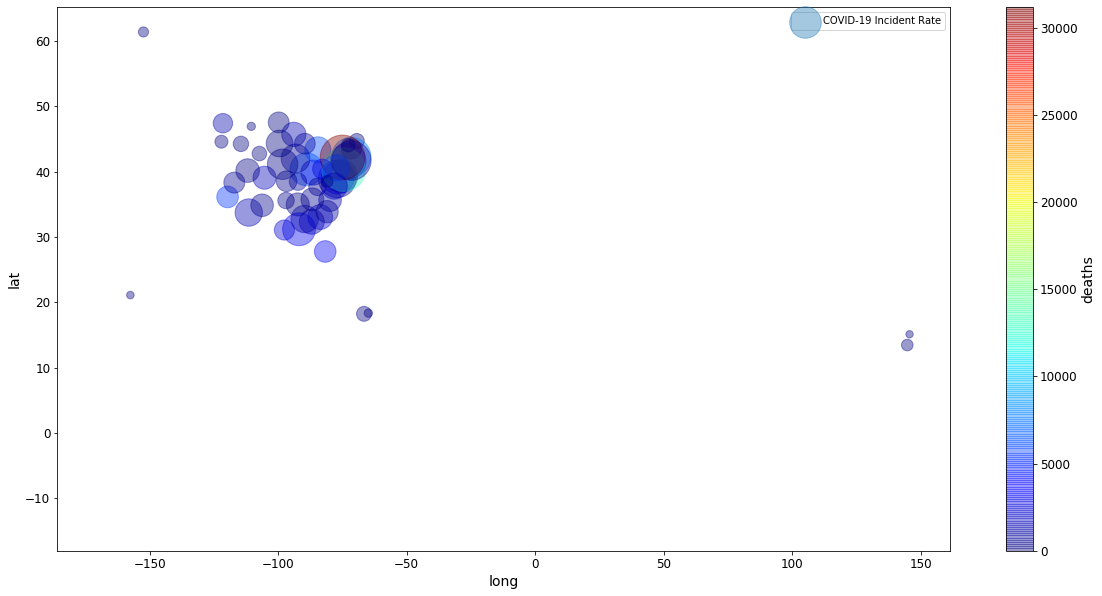

In [115]:
covid.plot(kind="scatter", x="long", y="lat", alpha=0.4,
    s=covid["incident_rate"], label="COVID-19 Incident Rate", figsize=(20,10),
    c="deaths", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

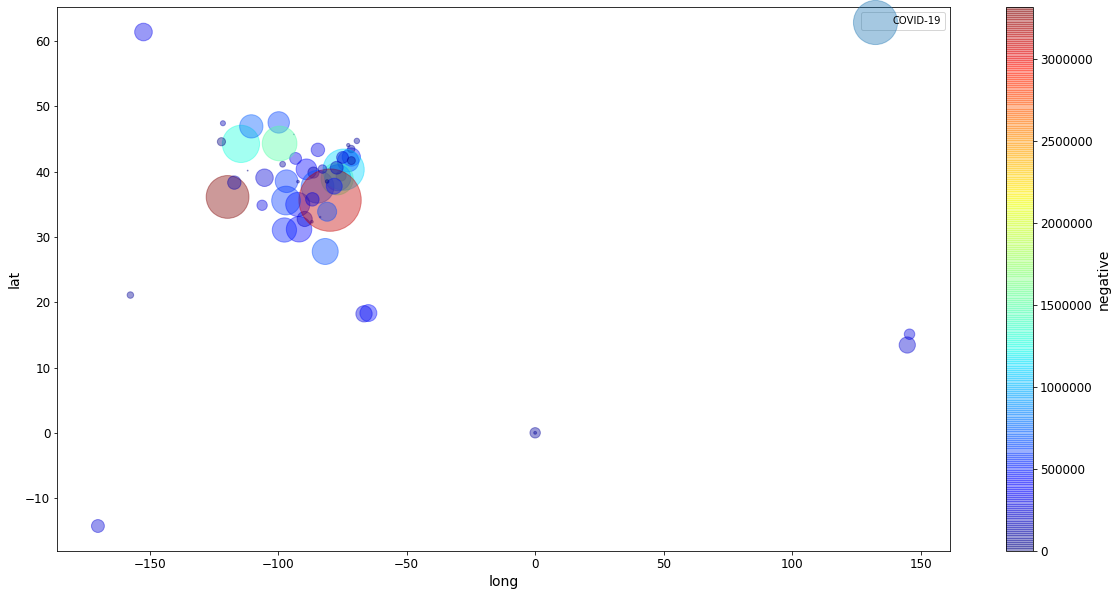

In [123]:
covid.plot(kind="scatter", x="long", y="lat", alpha=0.4,
    s=covid["positive"]/100, label="COVID-19", figsize=(20,10),
    c="negative", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

In [105]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

covid_nums = covid._get_numeric_data()

In [106]:
# Impute all missing data with the median 
imputer.fit(covid_nums)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [107]:
imputer.statistics_

array([ 3.89786000e+01, -8.67973000e+01,  1.79345000e+04,  5.33000000e+02,
        3.41950000e+03,  8.11300000e+03,  4.83054102e+02,  2.82715000e+05,
        5.84500000e+02,  3.43543108e+00,  7.69164738e+03,  7.88942611e+00,
        0.00000000e+00,  1.80500000e+04,  2.69904500e+05,  2.09000000e+02,
        5.91000000e+02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.49800000e+03,  5.39500000e+02,  5.91000000e+02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.73175000e+04,
        2.33500000e+02,  4.37200000e+03,  2.91466500e+05,  2.91466500e+05,
        4.78650000e+03,  2.91466500e+05,  4.50000000e+00,  2.50000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

array([ 3.89786000e+01, -8.67973000e+01,  1.79345000e+04,  5.33000000e+02,
        3.41950000e+03,  8.11300000e+03,  4.83054102e+02,  2.82715000e+05,
        5.84500000e+02,  3.43543108e+00,  7.69164738e+03,  7.88942611e+00,
        0.00000000e+00,  1.80500000e+04,  2.69904500e+05,  2.09000000e+02,
        5.91000000e+02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.49800000e+03,  5.39500000e+02,  5.91000000e+02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.73175000e+04,
        2.33500000e+02,  4.37200000e+03,  2.91466500e+05,  2.91466500e+05,
        4.78650000e+03,  2.91466500e+05,  4.50000000e+00,  2.50000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])